In [1]:
import json
import numpy as np
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVC
import collections
from math import log10
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, f1_score
from SMLP2_Func import generate_coauthors, onehot_func, coauthors_onehot, decode_func, convert_to_csv

## Read in Training and Test Data as Dataframe

In [2]:
f = open('train.json')
train_data = json.load(f)
train_X = pd.DataFrame(columns=["year", "venue", "title", "abstract"])
train_y = pd.DataFrame(columns=["authors"])
authors_list = []
year_list = []
venue_list = []
title_list = []
abstract_list = []
for i in range(len(train_data)): 
    authors_list.append(np.array(train_data[i]['authors']))
    year_list.append(np.array(train_data[i]['year']))
    venue_list.append(np.array(train_data[i]['venue']))
    title_list.append(np.array(train_data[i]['title']))
    abstract_list.append(np.array(train_data[i]['abstract']))

train_y["authors"] = authors_list
train_X["year"] = year_list
train_X["venue"] = venue_list
train_X["title"] = title_list
train_X["abstract"] = abstract_list

In [3]:
f = open('test.json')
test_data = json.load(f)
test_X = pd.DataFrame(columns=["year", "venue", "title", "abstract"])
coauthors_list = []
year_list = []
venue_list = []
title_list = []
abstract_list = []
for i in range(len(test_data)): 
    coauthors_list.append(np.array(test_data[i]['coauthors']))
    year_list.append(np.array(test_data[i]['year']))
    venue_list.append(np.array(test_data[i]['venue']))
    title_list.append(np.array(test_data[i]['title']))
    abstract_list.append(np.array(test_data[i]['abstract']))

test_X["year"] = year_list
test_X["venue"] = venue_list
test_X["title"] = title_list
test_X["abstract"] = abstract_list
test_X["coauthors"] = coauthors_list

## Define Variables

In [4]:
wordbag_len = 4999
authors_num = 21245
prolific_num = 100
venue_num = 465

## Splitting Authors' list into Response (Profilic Authors) & Predictors (Co-Authors)

In [5]:
prolific_authors_list = []
coauthors_list = []
for authors in authors_list:
    prolific_authors, coauthors = generate_coauthors(authors)
    prolific_authors_list.append(prolific_authors)
    coauthors_list.append(coauthors)

train_y["authors"] = prolific_authors_list
train_X["coauthors"] = coauthors_list

In [6]:
def get_threhold(venue_list, instance_amount): 
    freq_dict = {}
    for venue in venue_list: 
        # only consider non-empty venue 
        if venue.dtype != '<U1': 
            if int(venue) in freq_dict: 
                freq_dict[int(venue)] = freq_dict[int(venue)] + 1
            else: 
                freq_dict[int(venue)] = 1
    sorted_d = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)}
    
    return list(sorted_d.items())[0][1] / instance_amount

threhold = get_threhold(list(train_X["venue"].values), len(train_X["venue"]))

In [7]:
def get_import_word(train_X, type, threhold): 
    freq_dict = {}
    lst = list(train_X[type])
    for i in lst: 
        for j in list(set(i)): 
            if j in freq_dict: 
                freq_dict[j] += 1
            else: 
                freq_dict[j] = 1
    deleted_words = []
    for k in freq_dict: 
        if freq_dict[k] / len(train_X) > threhold: 
            deleted_words.append(k)
    return deleted_words
deleted_words = get_import_word(train_X, "title", threhold)
deleted_words = get_import_word(train_X, "abstract", threhold)

In [8]:
# Drop comment words (stop-word) for both training and test set
for i in range(len(train_X['title'])):
    train_X['title'][i] = [word for word in train_X['title'][i] if word not in deleted_words]
for i in range(len(train_X['abstract'])):
    train_X['abstract'][i] = [word for word in train_X['abstract'][i] if word not in deleted_words]
for i in range(len(test_X['title'])):
    test_X['title'][i] = [word for word in test_X['title'][i] if word not in deleted_words]
for i in range(len(test_X['abstract'])):
    test_X['abstract'][i] = [word for word in test_X['abstract'][i] if word not in deleted_words]

In [9]:
'''Function for Capturing the maximum length of the selected feature's element'''
def feature_max_len(feature, train_data, test_data):
    max_length = 0
    for i in range(train_X.shape[0]):
        if len(train_X[feature][i]) >= max_length:
            max_length = len(train_X[feature][i])
    for i in range(test_X.shape[0]):
        if len(test_X[feature][i]) >= max_length:
            max_length = len(test_X[feature][i])
    return max_length
title_len = feature_max_len("title", train_X, test_X)
abstract_len = feature_max_len("abstract", train_X, test_X)

## Convert Features 'title', 'abstract', 'coauthors' & 'authors' into One-hot Encoding Style

In [10]:
train_X = onehot_func(wordbag_len, train_X, "title")
train_X = onehot_func(wordbag_len, train_X, "abstract")
train_X = onehot_func(authors_num, train_X, "coauthors")
train_X = coauthors_onehot(prolific_num, train_X, "coauthors")
train_X = onehot_func(venue_num, train_X, "venue")
train_y = onehot_func(prolific_num, train_y, "authors")

test_X = onehot_func(wordbag_len, test_X, "title")
test_X = onehot_func(wordbag_len, test_X, "abstract")
test_X = onehot_func(authors_num, test_X, "coauthors")
test_X = coauthors_onehot(prolific_num, test_X, "coauthors")
test_X = onehot_func(venue_num, test_X, "venue")

In [11]:
# empty_row = []
# for i in range(len(train_y['authors'])):
#     if sum(train_y['authors'][i]) == 0:
#         empty_row.append(i)
# train_y_empty = train_y.iloc[empty_row]
# train_y_empty = train_y_empty.sample(n = 6000)
# indexdrop = train_y_empty.index
# train_y.drop(indexdrop, axis = 0, inplace = True)
# train_X.drop(indexdrop, axis = 0, inplace = True)

In [12]:
coauthors_list = []
for title in np.array(train_X['abstract']): 
    coauthors_list.append(list(title))
x_list_title = np.array(coauthors_list)

coauthors_list = []
for title in np.array(test_X['abstract']): 
    coauthors_list.append(list(title))
x_list_test_title = np.array(coauthors_list)

coauthors_list = []
for title in np.array(train_X['coauthors']): 
    coauthors_list.append(list(title))
x_list = np.array(coauthors_list)

y_list = []
for title in np.array(train_y['authors']): 
    y_list.append(list(title))
y_list = np.array(y_list)

coauthors_list_test = []
for title in np.array(test_X['coauthors']): 
    coauthors_list_test.append(list(title))
x_list_test = np.array(coauthors_list_test)

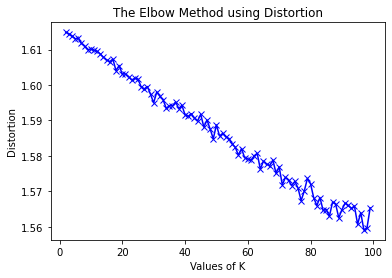

In [16]:
K = range(2, 100)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

# Select the best K amount of Clusters
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(x_list)
    distortions.append(sum(np.min(cdist(x_list, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_list.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(x_list, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_list.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [17]:
best_K = 99
k_best_Model = KMeans(n_clusters=best_K, random_state=0).fit(x_list)
model_list = []
for i in range(best_K):
    cluster_index = np.where(k_best_Model.labels_ == i)[0].tolist()
    cluster_x = x_list[cluster_index]
    cluster_y = y_list[cluster_index]
    classifier = LabelPowerset(GaussianNB())
    model_list.append(classifier.fit(cluster_x, cluster_y))

In [18]:
pred_cluster = k_best_Model.predict(x_list_test)
result_list = []
for i in range(len(pred_cluster)):
    y_pred = model_list[pred_cluster[i]].predict([x_list_test[i]])
    result_list.append(decode_func(y_pred)[0])
convert_to_csv(result_list)